In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import timeit

import os
import sys
root_path = os.getcwd() + "/scripts/personal/rick"
sys.path.append(str(root_path))

from prime_Functions_Andrew import *
from prime_Functions_quditV2 import *
np.set_printoptions(linewidth=200)

In [3]:
### Numerical Setup - constants
## general
shots = 12801
part_func = weighted_vertex_covering_maximal_cliques
full_simulation = True
intermediate_results_list = [6,12,25,50,100,200,400,800,1600,3200,6400,12800]
allocation_mode = 'set'

## Monte-Carlo
N = 500
N_max = 2001
mcmc_shot_scale = 0

## analysis
repeats = 4
p_noise = 0.01

### Numerical Setups - variable parameters
general_commutation_options = [True,False]
adaptive_options = [np.array([6,12,25,50,100,200,400,800,1600,3200,6400,12800,25600,51200,102400]),np.array([0])]

In [4]:
### Hamiltonian
#P,cc = read_luca_test_2("./Hamiltonians/"+"Hams"+"/"+"Periodic"+"/"+ "E_total_D3_Rick" +".txt",dims=3)
#P,cc = read_luca_test_2("./Hamiltonians/"+"Hams"+"/"+"Open"+"/"+ "D3" +".txt",dims=[2,2,2,2,3])
#P,cc = read_luca_test_2("./Hamiltonians/"+"Hams"+"/"+"Open"+"/"+ "full_D3_rev" +".txt",dims=[3,2,2,2,2])
P,cc = random_pauli_hamiltonian(20,[3,3,3])
P,cc,pauli_block_sizes = sort_hamiltonian(P,cc)
p,q = P.paulis(),P.qudits()
psi = ground_state(P,cc)
vg = variance_graph(P,cc,psi)

# Simulation
results = np.zeros((repeats,len(intermediate_results_list),6,4))
settings = ['GC + adaptive', 'GC + non-adaptive', 'BC + adaptive', 'BC + non-adaptive','Andrew','True Covariance']

for i_r in range(repeats):
    print('repeat:',i_r)
    start1 = timeit.default_timer()
    i_setting = 0
    
    # all combination of settings
    for general_commutation in general_commutation_options:
        for update_steps in adaptive_options:
            D = {}
            print('Setting: ', settings[i_setting])
            S,X,xxx,CG,X_list,S_list,D = bucket_filling_qudit(P,cc,psi,shots,part_func,pauli_block_sizes,
                                                              full_simulation=full_simulation,update_steps=update_steps,
                                                              general_commutation=general_commutation,D=D,
                                                              M_list = intermediate_results_list,
                                                              allocation_mode = allocation_mode,
                                                              mcmc_shot_scale = mcmc_shot_scale,
                                                              N_mcmc = N, N_mcmc_max = N_max,p_noise = p_noise,
                                                              Q_progress_bar=False)
            
            for k,X in enumerate(X_list):
                print('k',k)
                S = S_list[k]
                results[i_r,k,i_setting,0] = sum(cc[i0]*sum(X[i0,i0,i1]*math.e**(2*1j*math.pi*i1/P.lcm) for i1 in range(P.lcm))/sum(X[i0,i0,i1] for i1 in range(P.lcm)) if sum(X[i0,i0,i1] for i1 in range(P.lcm))>0 else 0 for i0 in range(p)).real
                results[i_r,k,i_setting,1] = np.sqrt(np.sum(scale_variances(graph(bayes_covariance_graph(X,np.array(cc),CG.adj,p,pauli_block_sizes,int(P.lcm),N=N ,N_max=N_max)),S).adj)).real
                results[i_r,k,i_setting,2] = np.sqrt(np.sum(scale_variances(vg,S).adj)).real
                results[i_r,k,i_setting,3] = error_correction_estimation(P,cc,X,xxx[0:intermediate_results_list[k]],p_noise)
                
            i_setting += 1
            print()
            print()
    
    # AEQuO by Andrew
    print('Setting: ', settings[i_setting])
    update_steps = np.array([6,12,25,50,100,200,400,800,1600,3200,6400,12800,25600,51200,102400])
    for k,M in enumerate(intermediate_results_list):
        print('k',k)
        S,X,xxx = bucket_filling_mod(P,cc,psi,M,part_func,update_steps=update_steps,repeats=(0,1),
                                     full_simulation=True,general_commutation=True,best_possible=False)
        results[i_r,k,i_setting,0] = sum(cc[i0]*sum(X[i0,i0][i1,i1]*math.e**(2*1j*math.pi*i1/P.lcm) for i1 in range(P.lcm))/sum(X[i0,i0][i1,i1] for i1 in range(P.lcm)) if sum(X[i0,i0][i1,i1] for i1 in range(P.lcm))>0 else 0 for i0 in range(p)).real
        results[i_r,k,i_setting,1] = np.sqrt(np.sum(scale_variances(bayes_variance_graph(X,cc),S).adj)).real
        results[i_r,k,i_setting,2] = np.sqrt(np.sum(scale_variances(vg,S).adj)).real
    i_setting += 1
    print()
    print()
    
    # Allocating according to true covariance
    print('Setting: ', settings[i_setting])
    S,X,xxx,CG,X_list,S_list,D = bucket_filling_qudit(P,cc,psi,shots,part_func,pauli_block_sizes,
                                                      full_simulation=True,update_steps=update_steps,
                                                      general_commutation=True,D={},
                                                      allocation_mode = allocation_mode,
                                                      M_list = intermediate_results_list,
                                                      mcmc_shot_scale = mcmc_shot_scale, best_possible=True,
                                                      N_mcmc = N, N_mcmc_max = N_max,Q_progress_bar=False)

    for k,X in enumerate(X_list):
        print('k',k)
        S = S_list[k]
        results[i_r,k,i_setting,0] = sum(cc[i0]*sum(X[i0,i0,i1]*math.e**(2*1j*math.pi*i1/P.lcm) for i1 in range(P.lcm))/sum(X[i0,i0,i1] for i1 in range(P.lcm)) if sum(X[i0,i0,i1] for i1 in range(P.lcm))>0 else 0 for i0 in range(p)).real
        results[i_r,k,i_setting,1] = np.sqrt(np.sum(scale_variances(graph(bayes_covariance_graph(X,np.array(cc),CG.adj,p,pauli_block_sizes,int(P.lcm),N=N ,N_max=N_max)),S).adj)).real
        results[i_r,k,i_setting,2] = np.sqrt(np.sum(scale_variances(vg,S).adj)).real
        results[i_r,k,i_setting,3] = error_correction_estimation(P,cc,X,xxx,p_noise)
        
    stop1 = timeit.default_timer()
    print()
    print('Time Repeat '+ str(i_r) +' : ',stop1-start1)
    print()
    print()
    print()
    
np.save("Random"+"D3"+"Noise=001_Results"+"N"+str(shots), results)
print()
print()

repeat: 0
Setting:  GC + adaptive


100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:53<00:00, 239.57it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  GC + non-adaptive


100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:13<00:00, 919.08it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  BC + adaptive


100%|██████████████████████████████████████████████████████████████████████████| 12801/12801 [00:08<00:00, 1475.96it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  BC + non-adaptive


100%|██████████████████████████████████████████████████████████████████████████| 12801/12801 [00:06<00:00, 1921.80it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  Andrew
k 0
k 1                                                                
k 2                                                                  
k 3                                                                  
k 4                                                                  
k 5                                                                   
k 6                                                                    
k 7                                                                    
k 8                                                                    
k 9                                                                      
k 10                                                                     
k 11                                                                     
                                                                           

Setting:  True Covariance


IntProgress(value=0, max=12)

100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:15<00:00, 835.46it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11

Time Repeat 0 :  201.03031929999997



repeat: 1
Setting:  GC + adaptive


100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:29<00:00, 429.59it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  GC + non-adaptive


100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:15<00:00, 827.08it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  BC + adaptive


100%|██████████████████████████████████████████████████████████████████████████| 12801/12801 [00:09<00:00, 1406.72it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  BC + non-adaptive


100%|██████████████████████████████████████████████████████████████████████████| 12801/12801 [00:07<00:00, 1680.36it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  Andrew
k 0
k 1                                                                
k 2                                                                  
k 3                                                                  
k 4                                                                  
k 5                                                                   
k 6                                                                    
k 7                                                                    
k 8                                                                    
k 9                                                                      
k 10                                                                     
k 11                                                                     
                                                                           

Setting:  True Covariance


IntProgress(value=0, max=12)

100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:15<00:00, 823.47it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11

Time Repeat 1 :  163.86039250000613



repeat: 2
Setting:  GC + adaptive


100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:27<00:00, 464.06it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  GC + non-adaptive


100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:14<00:00, 872.61it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  BC + adaptive


100%|██████████████████████████████████████████████████████████████████████████| 12801/12801 [00:09<00:00, 1336.92it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  BC + non-adaptive


100%|██████████████████████████████████████████████████████████████████████████| 12801/12801 [00:06<00:00, 1835.99it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  Andrew
k 0
k 1                                                                
k 2                                                                  
k 3                                                                  
k 4                                                                  
k 5                                                                   
k 6                                                                    
k 7                                                                    
k 8                                                                    
k 9                                                                      
k 10                                                                     
k 11                                                                     
                                                                           

Setting:  True Covariance


IntProgress(value=0, max=12)

100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:14<00:00, 854.98it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11

Time Repeat 2 :  159.23597919999156



repeat: 3
Setting:  GC + adaptive


100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:28<00:00, 455.60it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  GC + non-adaptive


100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:14<00:00, 878.50it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  BC + adaptive


100%|██████████████████████████████████████████████████████████████████████████| 12801/12801 [00:09<00:00, 1411.68it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  BC + non-adaptive


100%|██████████████████████████████████████████████████████████████████████████| 12801/12801 [00:06<00:00, 1908.86it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11


Setting:  Andrew
k 0
k 1                                                                
k 2                                                                  
k 3                                                                  
k 4                                                                  
k 5                                                                   
k 6                                                                    
k 7                                                                    
k 8                                                                    
k 9                                                                      
k 10                                                                     
k 11                                                                     
                                                                           

Setting:  True Covariance


IntProgress(value=0, max=12)

100%|███████████████████████████████████████████████████████████████████████████| 12801/12801 [00:15<00:00, 804.54it/s]


k 0
k 1
k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11

Time Repeat 3 :  161.93777859999682







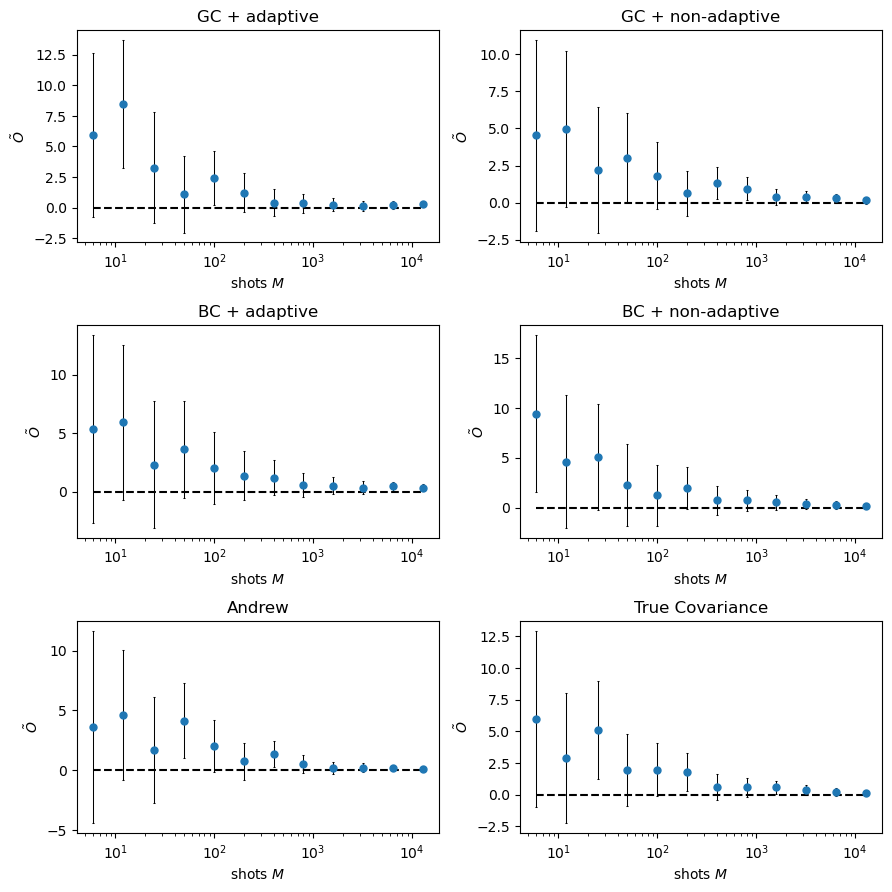

In [5]:
x_dat = intermediate_results_list
y_dat = np.zeros((6,len(intermediate_results_list)))
y_err_dat = np.zeros((6,len(intermediate_results_list)))

n_plot = [0,1,2,3,4,5]
H_mean = Hamiltonian_Mean(P,cc,psi).real

fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(9,9))

for i in n_plot: 
    for j in range(len(intermediate_results_list)): 
        y_dat[i,j] = np.mean(np.abs(results[:,j,i,0] - H_mean))
        y_err_dat[i,j] = np.sqrt(np.mean(results[:,j,i,1]**2 + results[:,j,i,3]))

        
for i in n_plot:
    ax[i//2,i%2].errorbar(x_dat[0:], y_dat[i,0:], yerr=y_err_dat[i,0:], fmt='o',ecolor='k',
                 capsize=1,capthick=0.75,markersize=5,elinewidth=0.75,label=settings[i])

    ax[i//2,i%2].set_xscale('log')
    ax[i//2,i%2].set_ylabel(r'$\tilde{O}$')
    ax[i//2,i%2].set_xlabel(r'shots $M$')
    ax[i//2,i%2].set_title(settings[i])
    ax[i//2,i%2].plot([x_dat[0],x_dat[-1]],[0,0],'k--')
    
plt.tight_layout(pad=1, w_pad=1, h_pad=1)
plt.show()

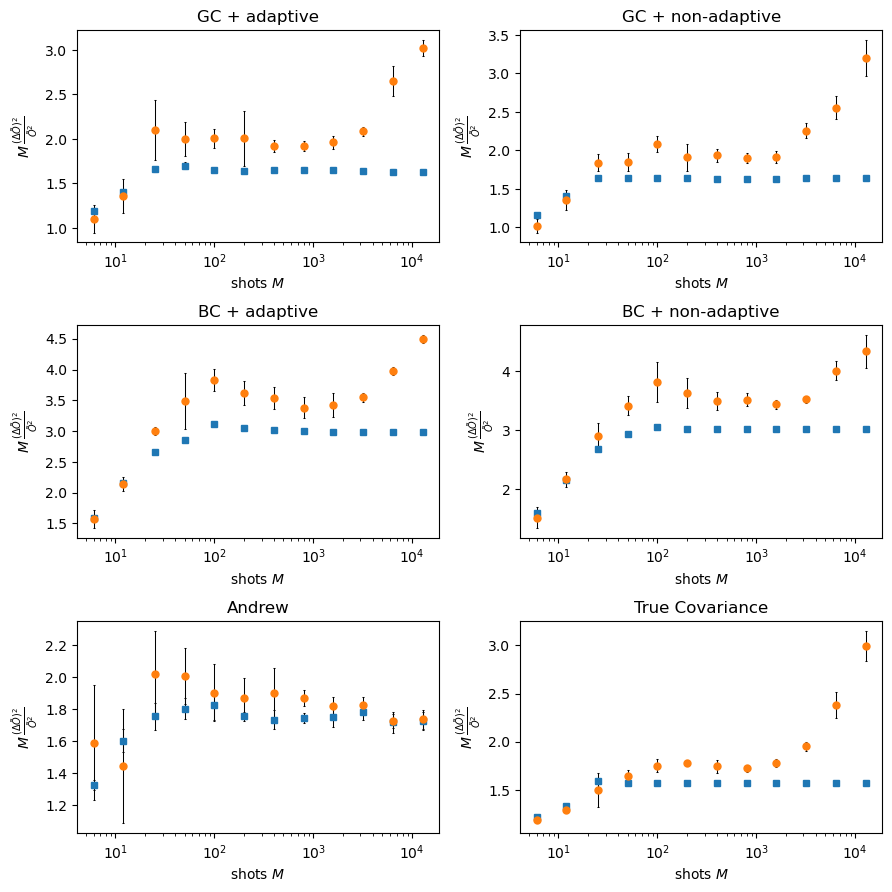

In [6]:
x_dat = intermediate_results_list
y_dat = np.zeros((6,len(intermediate_results_list)))
y_err_dat = np.zeros((6,len(intermediate_results_list)))

n_plot = [0,1,2,3,4,5]
H_mean = Hamiltonian_Mean(P,cc,psi).real

fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(9,9))

for i in n_plot: 
    for j in range(len(intermediate_results_list)): 
        y_dat[i,j] = np.mean((results[:,j,i,1]**2 + results[:,j,i,3]) * intermediate_results_list[j]/ (H_mean)**2)  
        y_err_dat[i,j] = np.std((results[:,j,i,1]**2 + results[:,j,i,3]) * intermediate_results_list[j] / (H_mean)**2) 

    
y_true_dat = np.zeros((6,len(intermediate_results_list)))
y_true_err_dat = np.zeros((6,len(intermediate_results_list)))
for i in n_plot: 
    for j in range(len(intermediate_results_list)): 
        y_true_dat[i,j] = np.mean(results[:,j,i,2]**2 * intermediate_results_list[j]/ (H_mean)**2)  
        y_true_err_dat[i,j] = np.std(results[:,j,i,2]**2 * intermediate_results_list[j] / (H_mean)**2)
        
for i in n_plot:
    ax[i//2,i%2].errorbar(x_dat[:], y_true_dat[i,:], yerr=y_true_err_dat[i,:], fmt='s',ecolor='k',
                 capsize=1,capthick=0.75,markersize=5,elinewidth=0.75,label=settings[i] + ' True Error')
    ax[i//2,i%2].set_xscale('log')
    ax[i//2,i%2].set_ylabel(r'$M \, \frac{(\Delta \tilde{O})^2}{\tilde{O}^2}$')
    ax[i//2,i%2].set_xlabel(r'shots $M$')
    ax[i//2,i%2].set_title(settings[i])
    
for i in n_plot:
    ax[i//2,i%2].errorbar(x_dat[:], y_dat[i,:], yerr=y_err_dat[i,:], fmt='o',ecolor='k',
                 capsize=1,capthick=0.75,markersize=5,elinewidth=0.75,label=settings[i])
    
plt.tight_layout(pad=1, w_pad=1, h_pad=1)
plt.show()